# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Loading the Data

In [2]:
# File paths (Updated to use only CSV dataset)
DATASET_PATH = "C:/Users/rachi/OneDrive/Desktop/spam_ham_dataset.csv"

# Constants
SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

In [3]:
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Drop rows with missing values
df.dropna(inplace=True)

# Display dataset info
print("Dataset loaded successfully.")
print(df.head())

Dataset loaded successfully.
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


# Reading File

In [4]:
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Drop rows where 'Message' is missing
df = df.dropna(subset=['text'])

# Check if there are valid messages
if not df.empty:
    email_body = df['text'].iloc[0]  # Get the first available email body
    print(email_body)
else:
    print("Error: No valid email bodies found in the dataset.")

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


# Email Body Extraction

In [5]:
def email_body_generator(path): 
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
        
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream: 
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)

            yield file_name, email_body

In [6]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'text': email_body, 'label_num': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [7]:
df = pd.read_csv(DATASET_PATH, encoding='latin1')

# Ensure necessary columns exist
if 'text' in df.columns and 'label_num' in df.columns:
    # Separate spam and ham emails
    spam_emails = df[df['label_num'] == 1]
    ham_emails = df[df['label_num'] == 0]

    # Display first few spam emails
    print("Spam Emails:")
    print(spam_emails.head())

    # Display first few ham emails
    print("\nHam Emails:")
    print(ham_emails.head())

Spam Emails:
    Unnamed: 0 label                                               text  \
3         4685  spam  Subject: photoshop , windows , office . cheap ...   
7         4185  spam  Subject: looking for medication ? we ` re the ...   
10        4922  spam  Subject: vocable % rnd - word asceticism\r\nvc...   
11        3799  spam  Subject: report 01405 !\r\nwffur attion brom e...   
13        3948  spam  Subject: vic . odin n ^ ow\r\nberne hotbox car...   

    label_num  
3           1  
7           1  
10          1  
11          1  
13          1  

Ham Emails:
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   
5        2949   ham  Subject: ehronline web address chang

In [8]:
spam_emails.shape

(1499, 4)

In [9]:
ham_emails.shape

(3672, 4)

In [10]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5171, 4)


Unnamed: 0 label                                               text  \
3         4685  spam  Subject: photoshop , windows , office . cheap ...   
7         4185  spam  Subject: looking for medication ? we ` re the ...   
10        4922  spam  Subject: vocable % rnd - word asceticism\r\nvc...   
11        3799  spam  Subject: report 01405 !\r\nwffur attion brom e...   
13        3948  spam  Subject: vic . odin n ^ ow\r\nberne hotbox car...   

    label_num  
3           1  
7           1  
10          1  
11          1  
13          1

In [11]:
data.tail()

Unnamed: 0 label                                               text  \
5165        2849   ham  Subject: fw : crosstex energy , driscoll ranch...   
5166        1518   ham  Subject: put the 10 on the ft\r\nthe transport...   
5167         404   ham  Subject: 3 / 4 / 2000 and following noms\r\nhp...   
5168        2933   ham  Subject: calpine daily gas nomination\r\n>\r\n...   
5169        1409   ham  Subject: industrial worksheets for august 2000...   

      label_num  
5165          0  
5166          0  
5167          0  
5168          0  
5169          0

# Data Cleaning: Checking for Missing Values

In [12]:
data['text'].isnull().values.any()

np.False_

In [13]:
(data.text.str.len()==0).any()

np.False_

In [14]:
empty_messages=(data['text'].str.len()==0).sum()
print(int(empty_messages))

0


# Add Document IDs to Track Emails in Dataset

In [15]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [16]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

Unnamed: 0 label                                               text  \
DOC_ID                                                                        
0             4685  spam  Subject: photoshop , windows , office . cheap ...   
1             4185  spam  Subject: looking for medication ? we ` re the ...   
2             4922  spam  Subject: vocable % rnd - word asceticism\r\nvc...   
3             3799  spam  Subject: report 01405 !\r\nwffur attion brom e...   
4             3948  spam  Subject: vic . odin n ^ ow\r\nberne hotbox car...   

        label_num  FILE_NAME  
DOC_ID                        
0               1          3  
1               1          7  
2               1         10  
3               1         11  
4               1         13

In [17]:
data.tail()

Unnamed: 0 label                                               text  \
DOC_ID                                                                        
5166          2849   ham  Subject: fw : crosstex energy , driscoll ranch...   
5167          1518   ham  Subject: put the 10 on the ft\r\nthe transport...   
5168           404   ham  Subject: 3 / 4 / 2000 and following noms\r\nhp...   
5169          2933   ham  Subject: calpine daily gas nomination\r\n>\r\n...   
5170          1409   ham  Subject: industrial worksheets for august 2000...   

        label_num  FILE_NAME  
DOC_ID                        
5166            0       5165  
5167            0       5166  
5168            0       5167  
5169            0       5168  
5170            0       5169

# Number of Spam Messages Visualised (Charts)

In [18]:
amount_of_spam=data['label_num'].value_counts().get(1,0)
amount_of_ham=data['label_num'].value_counts().get(0,0)
print(f"Spam Emails: {amount_of_spam}")
print(f"Ham Emails: {amount_of_ham}")

Spam Emails: 1499
Ham Emails: 3672


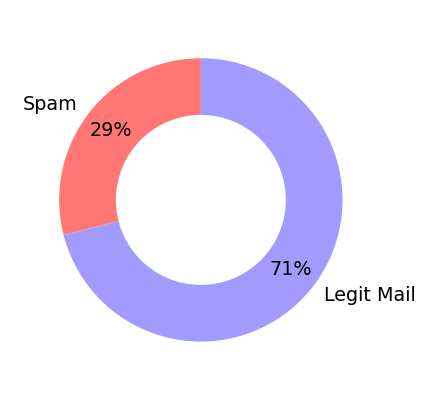

In [19]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675','#a29bfe']


plt.figure(figsize=(2,2), dpi = 230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle = 90, autopct = '%1.0f%%', colors = custom_colors, pctdistance = 0.8)


#making a donut

centre_circle = plt.Circle((0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Download the NLTK Resources (Tokenizer & Stopwords)

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_msg_no_html(message):
    if pd.isna(message) or not isinstance(message, str) or message.strip() == "":
        return ["empty"]  # Prevent empty lists

    soup = BeautifulSoup(str(message), 'html.parser')  
    cleaned_text = soup.get_text()
    
    try:
        words = word_tokenize(cleaned_text.lower())  
    except LookupError:
        words = cleaned_text.lower().split()

    filtered_words = [stemmer.stem(word) for word in words if word.isalpha() and len(word) > 1 and word not in stop_words]

    return filtered_words if filtered_words else ["empty"]  # Prevent empty lists

# Load dataset (assuming CSV format)
data = pd.read_csv("C:/Users/rachi/OneDrive/Desktop/spam_ham_dataset.csv")  # Change file path as needed

# Check the available column names
print("Dataset Columns:", data.columns)

# Ensure correct column name for emails
email_column = "text"  # Update if your column name is different

# Apply function to all emails while handling NaN values
data["Cleaned_Message"] = data[email_column].astype(str).fillna("").apply(clean_msg_no_html)

# Display first few cleaned emails
print(data[["Cleaned_Message"]].head())

Dataset Columns: Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')
                                     Cleaned_Message
0  [enron, methanol, meter, follow, note, gave, m...
1  [hpl, nom, januari, see, attach, file, hplnol,...
2  [neon, retreat, ho, ho, ho, around, wonder, ti...
3  [photoshop, window, offic, cheap, main, trend,...
4  [indian, spring, deal, book, teco, pvr, revenu...


# Apply Cleaning and Tokenization to all messages

## Slicing Dataframes and Series and Creating Subsets

In [26]:
%%time

nested_list=data.text.apply(clean_msg_no_html)

CPU times: total: 12.5 s
Wall time: 19.7 s


In [27]:
nested_list.head()

0    [enron, methanol, meter, follow, note, gave, m...
1    [hpl, nom, januari, see, attach, file, hplnol,...
2    [neon, retreat, ho, ho, ho, around, wonder, ti...
3    [photoshop, window, offic, cheap, main, trend,...
4    [indian, spring, deal, book, teco, pvr, revenu...
Name: text, dtype: object

In [28]:
nested_list.tail()

5166    [put, ft, transport, volum, decreas, contract,...
5167    [follow, nom, hpl, take, extra, mmcf, weekend,...
5168    [calpin, daili, ga, nomin, juli, mention, earl...
5169    [industri, worksheet, august, activ, attach, w...
5170    [import, onlin, bank, alert, dear, valu, citiz...
Name: text, dtype: object

# Using Logic to Slice Dataframes

In [29]:
doc_ids_spam=data[data["label_num"]==1].index
doc_ids_ham=data[data["label_num"]==0].index

# Subsetting a Series with an index

In [30]:
nested_list_ham=nested_list.loc[doc_ids_ham]

In [31]:
nested_list_ham.shape

(3672,)

In [32]:
nested_list_spam=nested_list.loc[doc_ids_spam]

In [33]:
nested_list_spam.shape

(1499,)

In [34]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

12352

In [35]:
normal_words[:10]

ect        13897
hou         7281
enron       6555
deal        3549
ga          2895
pleas       2737
subject     2733
meter       2718
com         2717
cc          2379
Name: count, dtype: int64

In [36]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]

31471

In [37]:
spammy_words[:10]

com        992
http       984
compani    918
price      732
www        587
inform     556
get        555
font       515
email      513
pleas      506
Name: count, dtype: int64

# Word Cloud of Ham and Spam Messages

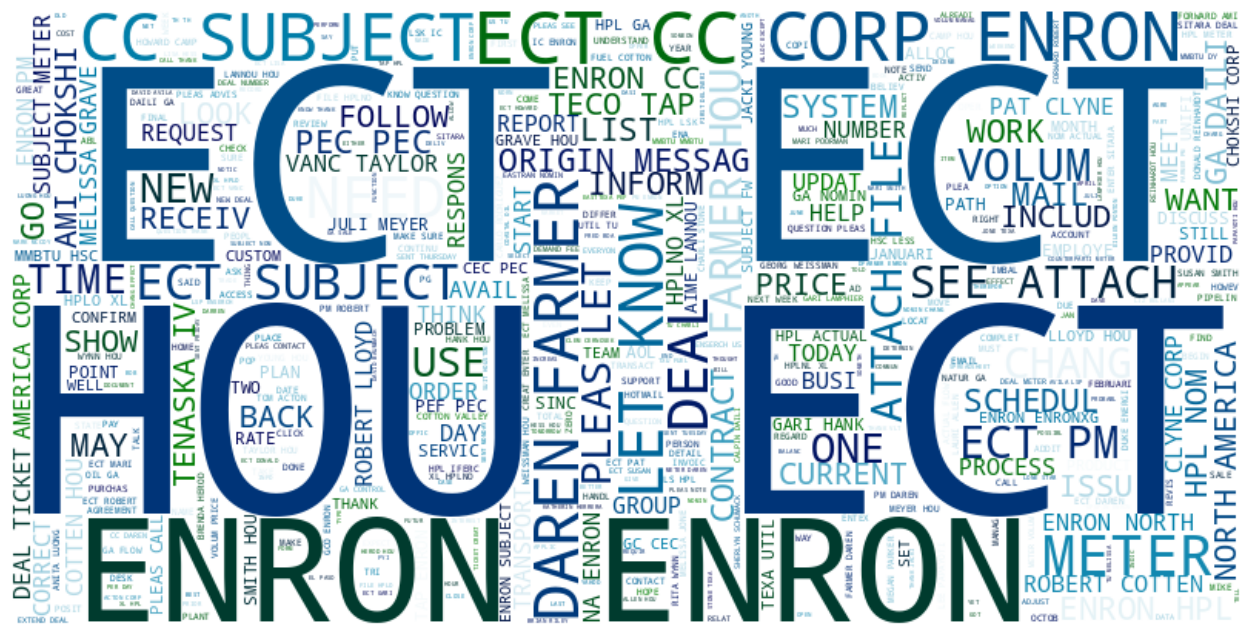

In [38]:
# ✅ Generate text from ham messages
ham_str = ' '.join(flat_list_ham)

# ✅ Create a word cloud without a mask
word_cloud = WordCloud(
    background_color='white',
    max_words=500,
    colormap='ocean',
    max_font_size=200,
    width=800, height=400  # Define image size manually
)

word_cloud.generate(ham_str.upper())

# ✅ Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

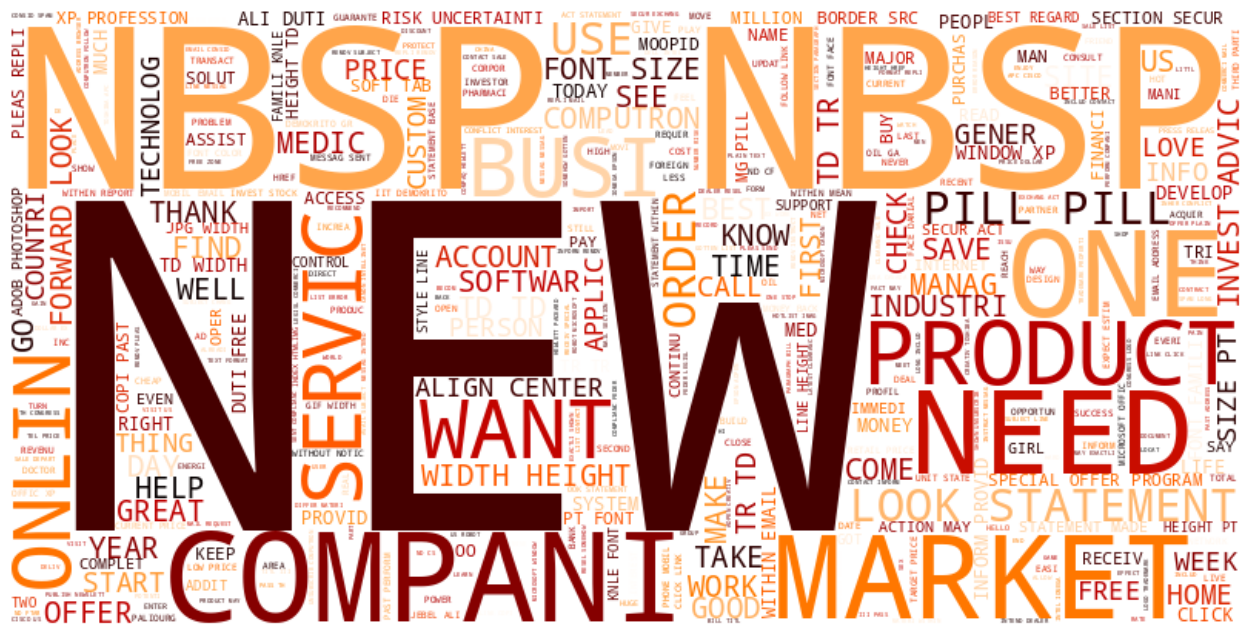

In [39]:
# ✅ Generate text from spam messages
spam_str = ' '.join(flat_list_spam)

# ✅ Create a word cloud without a mask
word_cloud = WordCloud(
    background_color='white',
    max_words=2000,
    colormap='gist_heat',  # 🔥 Heatmap colors
    max_font_size=300,
    width=800, height=400  # Define manual size
)

word_cloud.generate(spam_str.upper())

# ✅ Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [41]:
stemmed_nested_list=data.text.apply(clean_msg_no_html)
flat_stemmed_list=[item for sublist in stemmed_nested_list for item in sublist]

In [42]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
print('Number if unique words', unique_words.shape[0])
unique_words.head()

Number if unique words 37843


ect      13908
hou       7289
enron     6555
com       3709
deal      3655
Name: count, dtype: int64

In [43]:
frequent_words=unique_words[0:VOCAB_SIZE]
print('Most common words: \n',frequent_words[:10])

Most common words: 
 ect        13908
hou         7289
enron       6555
com         3709
deal        3655
pleas       3243
ga          3072
subject     2893
meter       2721
cc          2391
Name: count, dtype: int64


# Create Vocabulary DataFrame with a WORD_ID

In [44]:
word_ids=list(range(0,VOCAB_SIZE))
vocab=pd.DataFrame({'VOCAB_WORD': frequent_words.index.values},index=word_ids)
vocab.index.name='WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0              ect
1              hou
2            enron
3              com
4             deal

# Generate Features and a Sparse Matrix

## Creating a Dataframe with one word per column

In [45]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

0         1        2       3       4       5       6            7     \
0      enron  methanol    meter  follow    note    gave  monday  preliminari   
1        hpl       nom  januari     see  attach    file  hplnol           xl   
2       neon   retreat       ho      ho      ho  around  wonder         time   
3  photoshop    window    offic   cheap    main   trend    abas        darer   
4     indian    spring     deal    book    teco     pvr  revenu   understand   

      8        9     ...  3291  3292  3293  3294  3295  3296  3297  3298  \
0     flow     data  ...  None  None  None  None  None  None  None  None   
1   hplnol       xl  ...  None  None  None  None  None  None  None  None   
2     year     neon  ...  None  None  None  None  None  None  None  None   
3  prudent  fortuit  ...  None  None  None  None  None  None  None  None   
4     teco     send  ...  None  None  None  None  None  None  None  None   

   3299  3300  
0  None  None  
1  None  None  
2  None  None  
3  None  None  
4  None  None  

[5 rows x 3301 columns]

In [46]:
word_columns_df.shape

(5171, 3301)

# Splitting the Data into Training and Testing Dataset

In [48]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data["label_num"], test_size=0.3, random_state=42)

In [49]:
print('Number of training samples:', X_train.shape[0])
print('Fraction of training set:', X_train.shape[0]/word_columns_df.shape[0 ])

Number of training samples: 3619
Fraction of training set: 0.6998646296654419


In [50]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

0         1       2        3         4         5          6     \
DOC_ID                                                                      
1023    tenaska       see  demand      fee     chang   william      price   
4586     strong       buy   alert  monthli  newslett  topstock        mid   
2955    perform  feedback  chosen      one    direct    report     provid   
2495         hr   perform  object   binder      good      morn  afternoon   
3353         fw       fwd      fw     draw    school       age      child   

         7        8         9     ...  3291  3292  3293  3294  3295  3296  \
DOC_ID                            ...                                       
1023    chang     look     great  ...  None  None  None  None  None  None   
4586     week   report     alert  ...  None  None  None  None  None  None   
2955      mid     year  feedback  ...  None  None  None  None  None  None   
2495    today  everyon    receiv  ...  None  None  None  None  None  None   
3353       pa      fwd   thought  ...  None  None  None  None  None  None   

        3297  3298  3299  3300  
DOC_ID                          
1023    None  None  None  None  
4586    None  None  None  None  
2955    None  None  None  None  
2495    None  None  None  None  
3353    None  None  None  None  

[5 rows x 3301 columns]

In [51]:
y_train.head()

1023    0
4586    1
2955    0
2495    0
3353    0
Name: label_num, dtype: int64

# Create a Sparse Matrix for the Training Data

In [52]:
word_index = pd.Index(vocab.VOCAB_WORD)
from scipy.sparse import coo_matrix

def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns a DataFrame in the format: LABEL, DOC_ID, OCCURRENCE, WORD_ID.
    
    df: A DataFrame with words in columns and document IDs as index (X_train or X_test)
    indexed_words: Index of words ordered by word ID
    labels: Category as a Series (y_train or y_test)
    """
    
    word_set = set(indexed_words)
    
    # Identify positions where words exist in vocab
    mask = df.map(lambda x: x in word_set)
    doc_ids, word_texts = np.where(mask.values)  # Get row & column indices
    
    # Get corresponding words
    words_found = df.values[doc_ids, word_texts]
    
    # Convert words to word indices
    word_ids = [indexed_words.get_loc(word) for word in words_found]
    
    # Map row indices to actual document IDs
    doc_indices = df.index[doc_ids]  # These should match X_train.index
    
    # Ensure labels align with doc_indices
    labels_mapped = labels.reindex(doc_indices).values  # Safe mapping
    
    # Create DataFrame with the expected columns
    sparse_df = pd.DataFrame({
        "LABEL": labels_mapped,
        "DOC_ID": doc_indices,
        "OCCURENCE": 1,  # Each word appears once per row
        "WORD_ID": word_ids
    })

    return sparse_df

In [53]:
%%time
sparse_train_df=make_sparse_matrix(X_train,word_index,y_train)

CPU times: total: 3.02 s
Wall time: 4.71 s


In [55]:
sparse_train_df[:5]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    1023          1      155
1      0    1023          1       30
2      0    1023          1      334
3      0    1023          1      267
4      0    1023          1       27

In [56]:
sparse_train_df.shape

(271958, 4)

In [57]:
sparse_train_df[-5:]

LABEL  DOC_ID  OCCURENCE  WORD_ID
271953      0     860          1       33
271954      0     860          1       19
271955      0     860          1      125
271956      0     860          1       12
271957      0     860          1      200

# Combine Occurences with the Pandas groupby() Method

In [58]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       0              1
       5       0              1
       6       0              1
       8       0              1
       13      0              1

In [59]:
vocab.at[0,'VOCAB_WORD']

'ect'

In [60]:
train_grouped = train_grouped.reset_index()
train_grouped.head() 

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        2      0          1
1       0        5      0          1
2       0        6      0          1
3       0        8      0          1
4       0       13      0          1

In [61]:
train_grouped.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
157432    5165     1474      0          1
157433    5165     1518      0          1
157434    5165     1753      0          1
157435    5165     1868      0          1
157436    5165     2017      0          1

In [62]:
vocab.at[1908,'VOCAB_WORD']

'jason'

In [64]:
data.text[2011]

'Subject: sunday\r\nalpha male plus , the only multiple orgasm supplement for men !\r\nprevent premature ejaculat?on , become the ultimate sex machine .\r\nmultiple orgasms with no erection loss !\r\nyour easy - to - use solution is here : http : / / whiop . biz / alpha / ? utopia\r\n- - - - -\r\nlink below is for that people who dislike\r\nadv . . . . .\r\nhttp : / / whiop . biz / alpha / o . html\r\n'

In [65]:
train_grouped.shape

(157437, 4)

In [66]:
TRAINING_DATA_FILE="train-data2.txt"
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

# Create a Sparse Matrix for the Test Data

In [67]:
X_test.head()

0          1       2          3          4       5       6     \
DOC_ID                                                                     
1566        hpl        nom   march        see     attach    file   hplno   
1988      onlin  pharxmaci     med  disscount  phafrmaci  onlsin  grasnd   
1235        nom     actual   volum      april         th    agre  eileen   
2868      meter        dec  robert        put       head  togeth   decid   
4903    coastal        oil      ga     corpor    melissa    deal   creat   

          7            8          9     ...  3291  3292  3293  3294  3295  \
DOC_ID                                  ...                                 
1566        xl        hplno         xl  ...  None  None  None  None  None   
1988     opegn          med     orfder  ...  None  None  None  None  None   
1235    ponton        david      avila  ...  None  None  None  None  None   
2868     enter  partnership  agreement  ...  None  None  None  None  None   
4903     enter       sitara      addit  ...  None  None  None  None  None   

        3296  3297  3298  3299  3300  
DOC_ID                                
1566    None  None  None  None  None  
1988    None  None  None  None  None  
1235    None  None  None  None  None  
2868    None  None  None  None  None  
4903    None  None  None  None  None  

[5 rows x 3301 columns]

In [68]:
X_test.shape

(1552, 3301)

In [69]:
%%time

sparse_test_df=make_sparse_matrix(X_test,word_index,y_test)

CPU times: total: 1.23 s
Wall time: 2.22 s


In [70]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       8        2      0          2
1       8        3      0          2
2       8        7      0          1
3       8        9      0          1
4       8       11      0          1

In [71]:
test_grouped.shape

(67139, 4)

In [72]:
TEST_DATA_FILE="test-data2.txt"
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')